Numpy Icosphere Implementation
-------------------

In [2]:
# standard modules
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

# distance matrix module
from scipy.spatial.distance import cdist

First, I define the initial icosahedron using three intersecting orthogonal golden rectangles:

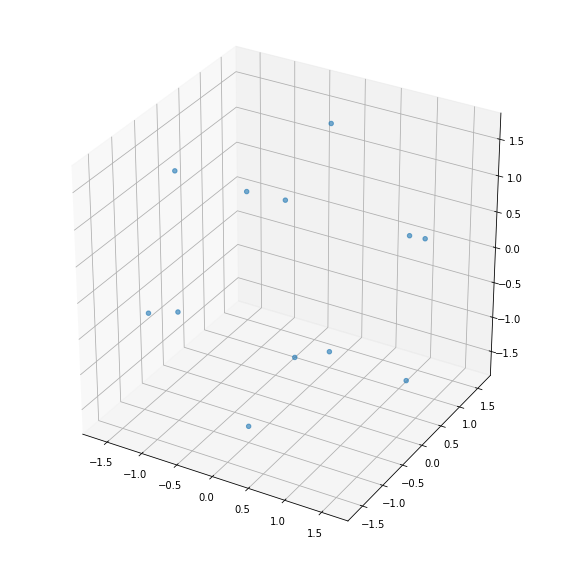

In [19]:
# golden ratio
R = (1 + np.sqrt(5)) / 2

vertices = np.array([[-1,R,0],
                     [1,R,0],
                     [-1,-R,0],
                     [1,-R,0],

                     [0,-1,R],
                     [0,1,R],
                     [0,-1,-R],
                     [0,1,-R],

                     [R,0,-1],
                     [R,0,1],
                     [-R,0,-1],
                     [-R,0,1]])

# plot
xu, yu, zu = vertices[:,0], vertices[:,1], vertices[:,2]
fig, ax = plt.subplots(1, 1, subplot_kw={'projection':'3d', 'aspect':'equal'}, figsize=(10,10))
ax.scatter(xu, yu, zu, zorder=10, alpha=.6)
plt.show()

Then, I infer which sets of indices make up the faces of the icosahedron. This is not too difficult to do manually for the initial icosahedron, but the beauty of this code is that it can be used to infer faces on every level of interpolation. [Scipy's `cdist` module](https://docs.scipy.org/doc/scipy-1.0.0/reference/generated/scipy.spatial.distance.cdist.html) is used to get a matrix of distances between each point.

In [15]:
# find euclidian distances between all points -
# gives us a matrix of distances
euclid_dists = cdist(vertices, vertices)

# find list of adjacent vertices
sides_idx = np.where(
    euclid_dists == np.min(euclid_dists[euclid_dists > 0]))

# concatenate output locations into one array
sides_idx = np.concatenate(
    (sides_idx[0].reshape(-1,1), sides_idx[1].reshape(-1,1)), axis=1)

# remove duplicate sides_idx (there are many)
_, idx = np.unique(np.sort(sides_idx), axis=0, return_index=True)
sides_idx = sides_idx[idx]

`sides_idx` now contains a list of pairs of vertices that make the sides of the icosahedron.

In [18]:
sides_idx

array([[ 0,  1],
       [ 0,  5],
       [ 0,  7],
       [ 0, 10],
       [ 0, 11],
       [ 1,  5],
       [ 1,  7],
       [ 1,  8],
       [ 1,  9],
       [ 2,  3],
       [ 2,  4],
       [ 2,  6],
       [ 2, 10],
       [ 2, 11],
       [ 3,  4],
       [ 3,  6],
       [ 3,  8],
       [ 3,  9],
       [ 4,  5],
       [ 4,  9],
       [ 4, 11],
       [ 5,  9],
       [ 5, 11],
       [ 6,  7],
       [ 6,  8],
       [ 6, 10],
       [ 7,  8],
       [ 7, 10],
       [ 8,  9],
       [10, 11]], dtype=int64)

Then, I work out which of these sides connect to make faces:

In [20]:
# set up empty array
faces_idx = np.array([], dtype=int)

for i in np.unique(sides_idx[:,0]):
    # extract sides_idx related to each vertex
    a = sides_idx[np.where(sides_idx[:,0] == i),1]

    for j in a:
        for l in j:
            # find 3rd adjacent vertices common to both points
            b = sides_idx[np.where(sides_idx[:,0] == l), 1]
            intersect = np.intersect1d(a,b).reshape(-1,1)

            for m in intersect:
                # add faces_idx to array
                faces_idx = np.append(faces_idx, np.array([i,l,m]))

# output is a 1D list, so we need to reshape it
faces_idx = faces_idx.reshape(-1,3)


This outputs a list of the triads of points that make faces:

In [21]:
faces_idx

array([[ 0,  1,  5],
       [ 0,  1,  7],
       [ 0,  5, 11],
       [ 0,  7, 10],
       [ 0, 10, 11],
       [ 1,  5,  9],
       [ 1,  7,  8],
       [ 1,  8,  9],
       [ 2,  3,  4],
       [ 2,  3,  6],
       [ 2,  4, 11],
       [ 2,  6, 10],
       [ 2, 10, 11],
       [ 3,  4,  9],
       [ 3,  6,  8],
       [ 3,  8,  9],
       [ 4,  5,  9],
       [ 4,  5, 11],
       [ 6,  7,  8],
       [ 6,  7, 10]], dtype=int64)

Plugging these indices into our actual vertex co-ordinates gives us a face co-ordinates list (a three-dimensional numpy array):

In [30]:
# 3D matrix with xyz co-ordnates for vertices of all faces
v = vertices[faces_idx]
v

array([[[-1.        ,  1.61803399,  0.        ],
        [ 1.        ,  1.61803399,  0.        ],
        [ 0.        ,  1.        ,  1.61803399]],

       [[-1.        ,  1.61803399,  0.        ],
        [ 1.        ,  1.61803399,  0.        ],
        [ 0.        ,  1.        , -1.61803399]],

       [[-1.        ,  1.61803399,  0.        ],
        [ 0.        ,  1.        ,  1.61803399],
        [-1.61803399,  0.        ,  1.        ]],

       [[-1.        ,  1.61803399,  0.        ],
        [ 0.        ,  1.        , -1.61803399],
        [-1.61803399,  0.        , -1.        ]],

       [[-1.        ,  1.61803399,  0.        ],
        [-1.61803399,  0.        , -1.        ],
        [-1.61803399,  0.        ,  1.        ]],

       [[ 1.        ,  1.61803399,  0.        ],
        [ 0.        ,  1.        ,  1.61803399],
        [ 1.61803399,  0.        ,  1.        ]],

       [[ 1.        ,  1.61803399,  0.        ],
        [ 0.        ,  1.        , -1.61803399],
        

We can then find the midpoints of each side all in one go to generate the smaller triangles by using [numpy's `roll` function](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.roll.html). This moves each element of an array along one space, reintroducing elements that fall off the end back at the beginning. By adding the rolled version of the `v` array to the original version and dividing by 2, we calculate the midpoints of each pair of points in one go:

In [25]:
midpoints = ((v + np.roll(v,1,axis=1)) / 2).reshape(-1,3)

In [28]:
midpoints

array([[-0.5       ,  1.30901699,  0.80901699],
       [ 0.        ,  1.61803399,  0.        ],
       [ 0.5       ,  1.30901699,  0.80901699],
       [-0.5       ,  1.30901699, -0.80901699],
       [ 0.        ,  1.61803399,  0.        ],
       [ 0.5       ,  1.30901699, -0.80901699],
       [-1.30901699,  0.80901699,  0.5       ],
       [-0.5       ,  1.30901699,  0.80901699],
       [-0.80901699,  0.5       ,  1.30901699],
       [-1.30901699,  0.80901699, -0.5       ],
       [-0.5       ,  1.30901699, -0.80901699],
       [-0.80901699,  0.5       , -1.30901699],
       [-1.30901699,  0.80901699,  0.5       ],
       [-1.30901699,  0.80901699, -0.5       ],
       [-1.61803399,  0.        ,  0.        ],
       [ 1.30901699,  0.80901699,  0.5       ],
       [ 0.5       ,  1.30901699,  0.80901699],
       [ 0.80901699,  0.5       ,  1.30901699],
       [ 1.30901699,  0.80901699, -0.5       ],
       [ 0.5       ,  1.30901699, -0.80901699],
       [ 0.80901699,  0.5       , -1.309

It is then simply a case of adding the new midpoints to the list of vertices and removing duplicates, and we have the points of our interpolated icosahedron:

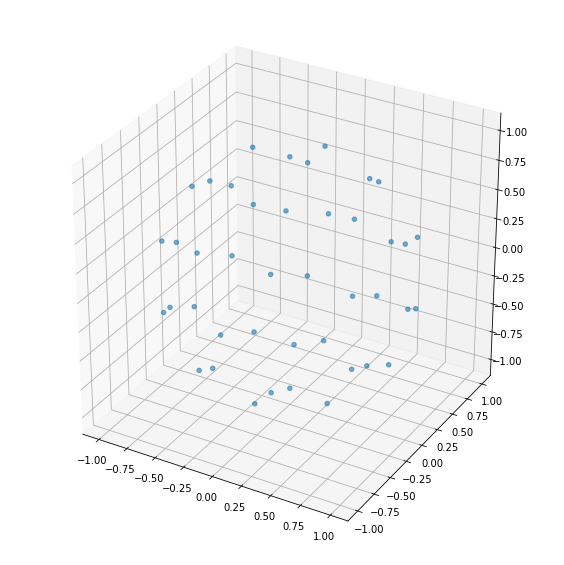

In [34]:
# add new vertices to list
vertices = np.append(vertices, midpoints, axis=0)
# find duplicate vertices
_, idx = np.unique(vertices, axis=0, return_index=True)
# remove duplicates and re-sort vertices
vertices = vertices[np.sort(idx)]

# normalise points to surface of unit sphere
vertices = normalise(vertices, axis=1)

# plot
xu, yu, zu = vertices[:,0], vertices[:,1], vertices[:,2]
fig, ax = plt.subplots(1, 1, subplot_kw={'projection':'3d', 'aspect':'equal'}, figsize=(10,10))
ax.scatter(xu, yu, zu, zorder=10, alpha=.6)
plt.show()

And there you have it. To calculate further levels of interpolations to get more vertices, you simply use the output of the first interpolation as the input in place of the icosahedron at the beginning of this process and the whole thing can be looped. It's important **not** to normalise the points to the unit sphere if you intend to proceed to higher orders of interpolation as this causes the inference of faces stage (`cdist` etc.) not to work properly. Always normalise at the *end* of the process only.

My function that automates this whole process can be found in **https://github.com/marc1701/area-beamforming/blob/SRP_dev/spherical_sampling.py**. With this function you can specify your desired level of interpolation, whether or not to receive output as cartesian or spherical co-ordinates, and also whether you'd like to receive points specifying the *faces* of the interpolated icosahedron rather than the vertices (similarly to how a dodecahedron is the 'dual' of an icosahedron, with faces and vertices interchanged).

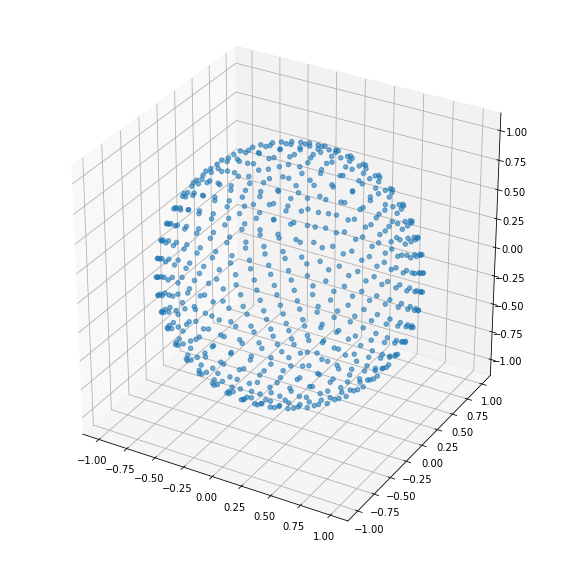

In [55]:
from spherical_sampling import geodesic

vertices = geodesic(3, co_ords='cart')

# plot
xu, yu, zu = vertices[:,0], vertices[:,1], vertices[:,2]
fig, ax = plt.subplots(1, 1, subplot_kw={'projection':'3d', 'aspect':'equal'}, figsize=(10,10))
ax.scatter(xu, yu, zu, zorder=10, alpha=.6)
plt.show()